# Checks for Lifestyle inflation


## Read the checkings account data from the csv file

In [37]:
import sys
import pandas as pd

sys.path.insert(0, "util.py")
import util

In [38]:
### Create checking data ###
df_checkings = util.combine_dfs("Bank_Data", "checkings.csv")
df_checkings = df_checkings.set_index("Posting Date")
df_checkings.index = pd.to_datetime(df_checkings.index)

### Inspect the data

In [39]:
df_checkings.head()

,Details,Amount,Type,Balance,Check or Slip #
Posting Date,,,,,
2010-01-01,DEBIT,-79.0,DEBIT_CARD,813.46,NaN
2010-01-02,DEBIT,-799.0,ACCT_XFER,13.46,NaN
2010-01-03,DEBIT,-799.0,ACCT_XFER,13.46,NaN
2010-01-04,DEBIT,-799.0,ACCT_XFER,13.46,NaN
2010-01-05,DEBIT,-799.0,ACCT_XFER,13.46,NaN


### Remove unnecessary columns

In [40]:
# Remove unnecessary columns
df_checkings.drop(columns=["Check or Slip #", "Type", "Details"], inplace=True)
df_checkings.tail()

,Amount,Balance
Posting Date,,
2011-12-27,-125.14,4693.48
2011-12-28,-125.14,4693.48
2011-12-29,-125.14,4693.48
2011-12-30,-125.14,4693.48
2011-12-31,-175.90,3697.04


### Amount Column
- Consists of positive and negative floating point numbers. 
- Negative numbers indicate payments/withdrawals and positive numbers indicate deposits.
- Create two new columns: payments/withdrawals and deposits.


In [41]:
### Amount column can be split into two columns: payments and deposits ###
import numpy as np

df_checkings["Payment/Withdrawal"] = df_checkings["Amount"].apply(
    lambda x: x if x < 0 else np.NaN
)
df_checkings["Deposit"] = df_checkings["Amount"].apply(
    lambda x: x if x >= 0 else np.NaN
)

### Plot the new columns

In [42]:
df_checkings

,Amount,Balance,Payment/Withdrawal,Deposit
Posting Date,,,,
2010-01-01,-79.00,813.46,-79.00,NaN
2010-01-02,-799.00,13.46,-799.00,NaN
2010-01-03,-799.00,13.46,-799.00,NaN
2010-01-04,-799.00,13.46,-799.00,NaN
2010-01-05,-799.00,13.46,-799.00,NaN
...,...,...,...,...
2011-12-27,-125.14,4693.48,-125.14,NaN
2011-12-28,-125.14,4693.48,-125.14,NaN
2011-12-29,-125.14,4693.48,-125.14,NaN


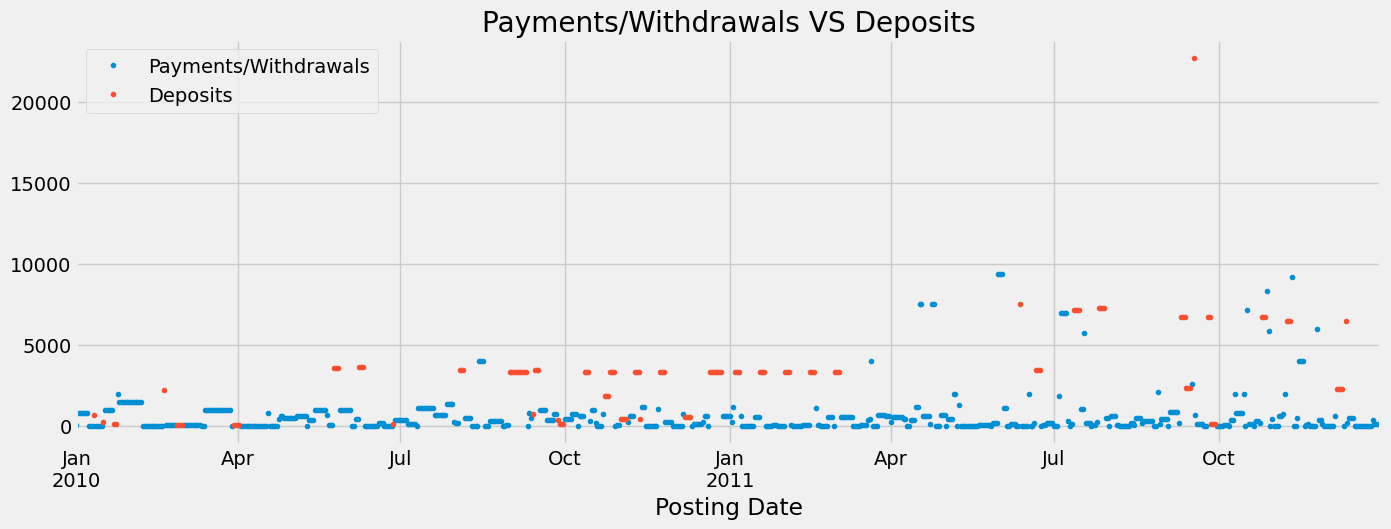

In [43]:
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")


pw_df = df_checkings["Payment/Withdrawal"].apply(lambda x: np.abs(x))
deposits_df = df_checkings["Deposit"]

# plot the new columns
fig, ax = plt.subplots(figsize=(15, 5))
pw_df.plot(
    ax=ax,
    style=".",
    label="Payments/Withdrawals",
    title="Payments/Withdrawals VS Deposits",
)
deposits_df.plot(ax=ax, style=".", label="Deposits")
ax.legend(["Payments/Withdrawals", "Deposits"])
plt.show()

## Calculate Lifestyle Inflation
- Is there a correlation between the amount of money spent and the amount of money deposited?

In [44]:
# Calculate the correlation between the two columns

amount_df = pd.DataFrame()
amount_df["Payment/Withdrawal"] = df_checkings["Amount"].apply(lambda x: min(x, 0))
amount_df["Deposit"] = df_checkings["Amount"].apply(lambda x: max(x, 0))

amount_df.corr()

,Payment/Withdrawal,Deposit
Payment/Withdrawal,1.000000,0.138436
Deposit,0.138436,1.000000


## So the two columns aren't correlated...right? 
- Take the rolling average between the two columns and plot it.

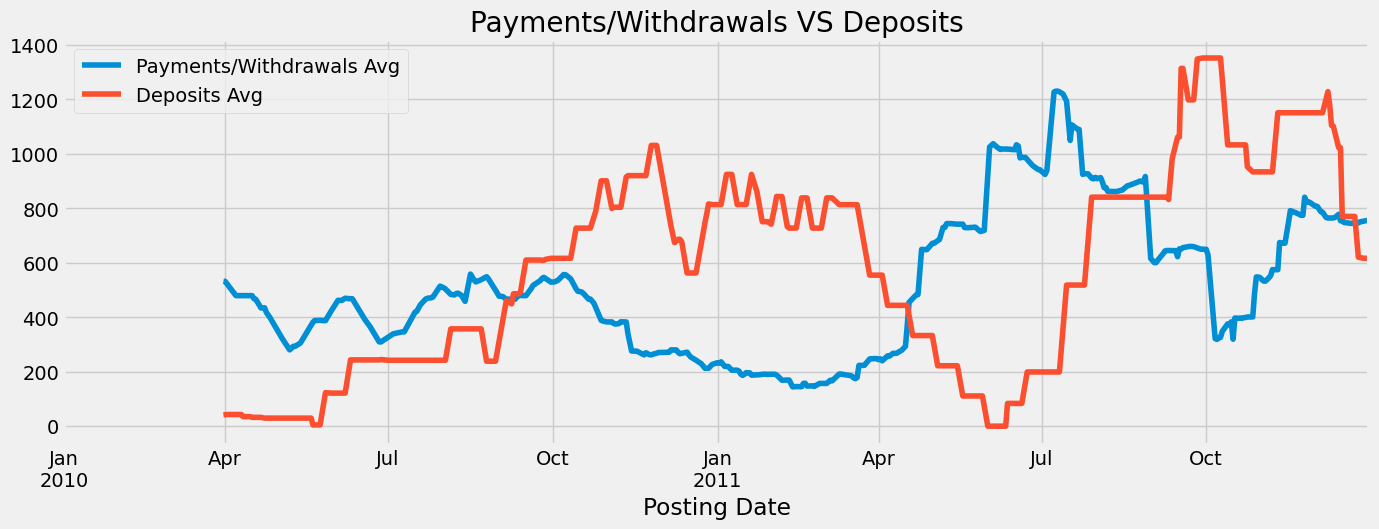

In [45]:
# Take the rolling mean of the two columns
window = 90
pw_avg_df = amount_df["Payment/Withdrawal"].apply(lambda x: np.abs(x))
pw_avg_df = pw_avg_df.rolling(window=window).mean()
deposit_avg_df = amount_df["Deposit"].rolling(window=window).mean()

amount_df["DepositAvg"] = deposit_avg_df
amount_df["Payment/WithdrawalAvg"] = pw_avg_df

# plot the avg columns
fig, ax = plt.subplots(figsize=(15, 5))
pw_avg_df.plot(
    ax=ax, label="Payments/Withdrawals Avg", title="Payments/Withdrawals VS Deposits"
)
deposit_avg_df.plot(ax=ax, label="Deposits Avg")
ax.legend(["Payments/Withdrawals Avg", "Deposits Avg"])
plt.show()

## Check if there is a correlation between the rolling averages
- Try to align the rolling averages of the deposits and withdrawals by shifting the deposits by 2 month

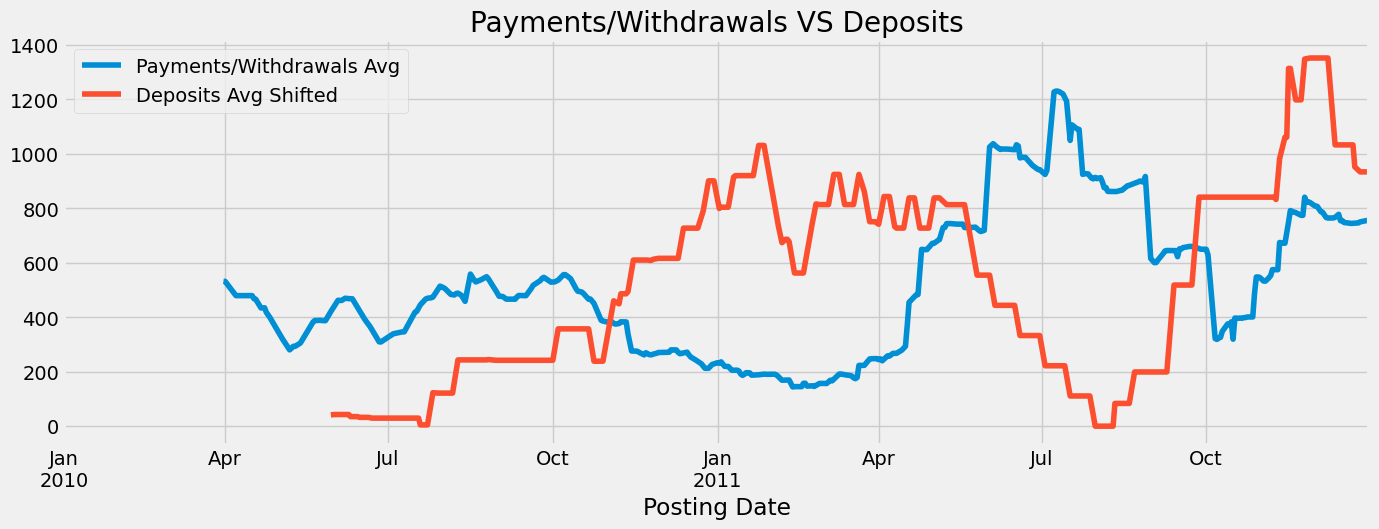

In [46]:
# shift the deposit avg column
amount_df["DepositAvgShift"] = amount_df["DepositAvg"].shift(60, axis=0)

# plot the avg columns
fig, ax = plt.subplots(figsize=(15, 5))
amount_df["Payment/WithdrawalAvg"].plot(
    ax=ax, label="Payments/Withdrawals Avg", title="Payments/Withdrawals VS Deposits"
)
amount_df["DepositAvgShift"].plot(ax=ax, label="Deposits Avg Shifted")
ax.legend(["Payments/Withdrawals Avg", "Deposits Avg Shifted"])
plt.show()

In [47]:
amount_df.corr()

,Payment/Withdrawal,Deposit,DepositAvg,Payment/WithdrawalAvg,DepositAvgShift
Payment/Withdrawal,1.000000,0.138436,0.072914,-0.148045,-0.026158
Deposit,0.138436,1.000000,0.152101,0.061358,-0.036843
DepositAvg,0.072914,0.152101,1.000000,-0.113532,0.515580
Payment/WithdrawalAvg,-0.148045,0.061358,-0.113532,1.000000,-0.207665
DepositAvgShift,-0.026158,-0.036843,0.515580,-0.207665,1.000000


## Yikes! Lifestyle Inflation is real!
### There is a very high correlation between the rolling averages of the deposits and withdrawals. (91.9%)